# Chapter 5

## Chapter 5.1

Because most correlations do not indicate causal relationships, we need tools for distinguising mere association from evidence of causation. 

In [2]:
import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from aesara import shared
from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata

warnings.simplefilter(action="ignore", category=FutureWarning)


In [3]:
!pip freeze | wc

    134     134    2430


In [4]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In [5]:
# Load data
data = pd.read_csv("../Data/WaffleDivorce.csv", delimiter=";")


In [6]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [7]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

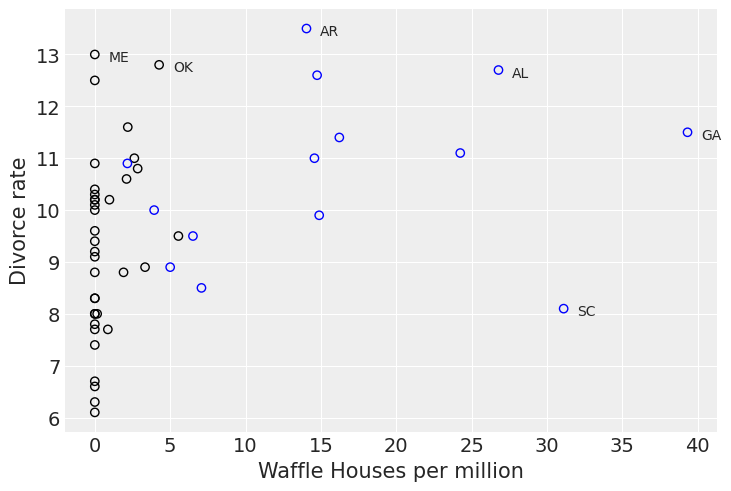

In [8]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

Text(0.5, 0, 'Median age marriage')

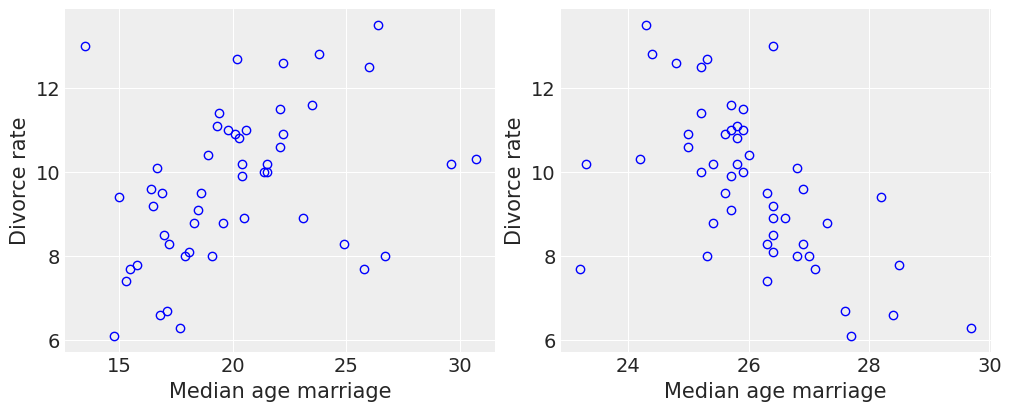

In [9]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Median age marriage")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

#### Code 5.1

In [10]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [11]:
data["MedianAgeMarriage"].std()

1.2436303013880823

#### Code 5.3

In [12]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Sampling: [a, bA, divorce_rate_std, sigma]
/home/gretar/Git/LEARNING/Bayesian_Statistics/statistical_rethinking/python-version/env/lib/python3.10/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, object, Mapping]
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Auto-assigning NUTS 

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


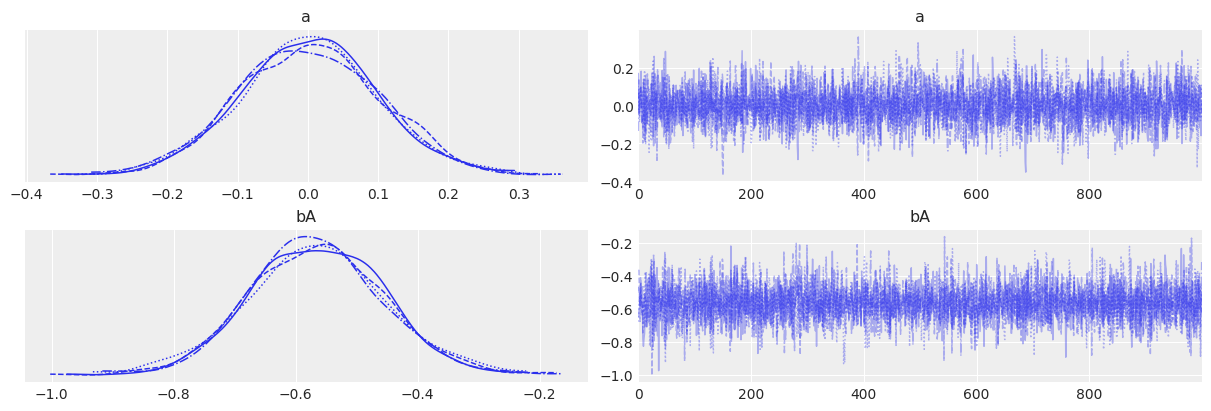

In [13]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

#### Code 5.4

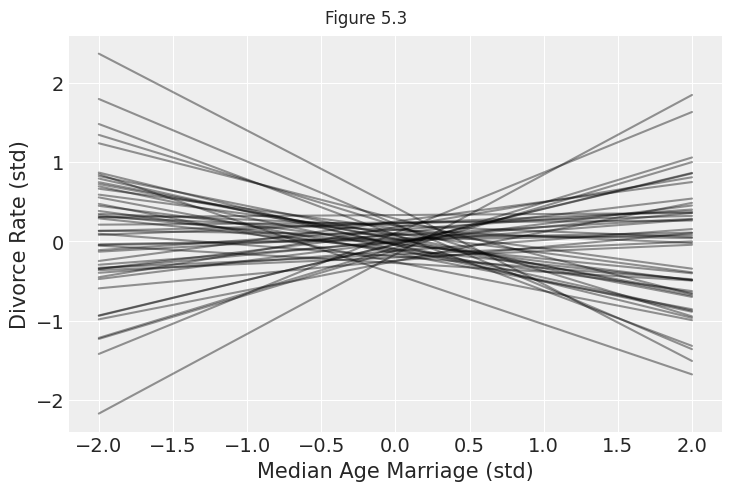

In [14]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

#### Code 5.5

In [15]:
m_5_1_trace.posterior["bA"].shape

(4, 1000)

In [16]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None, None, 10))
m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std

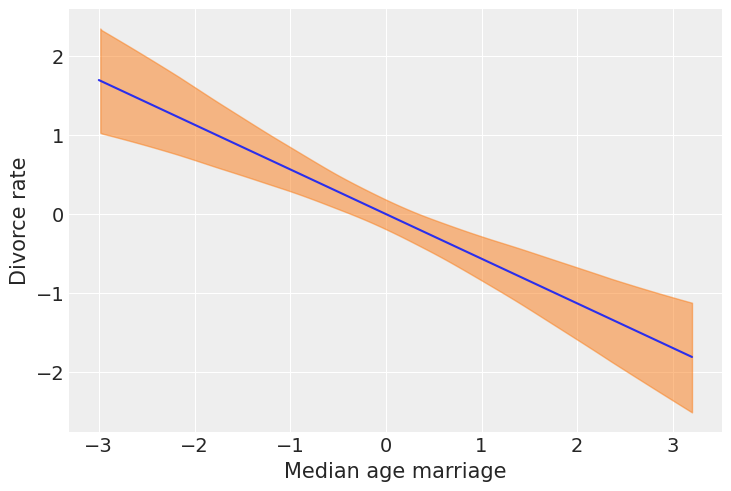

In [17]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

#### 5.6

In [18]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Sampling: [a, bM, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


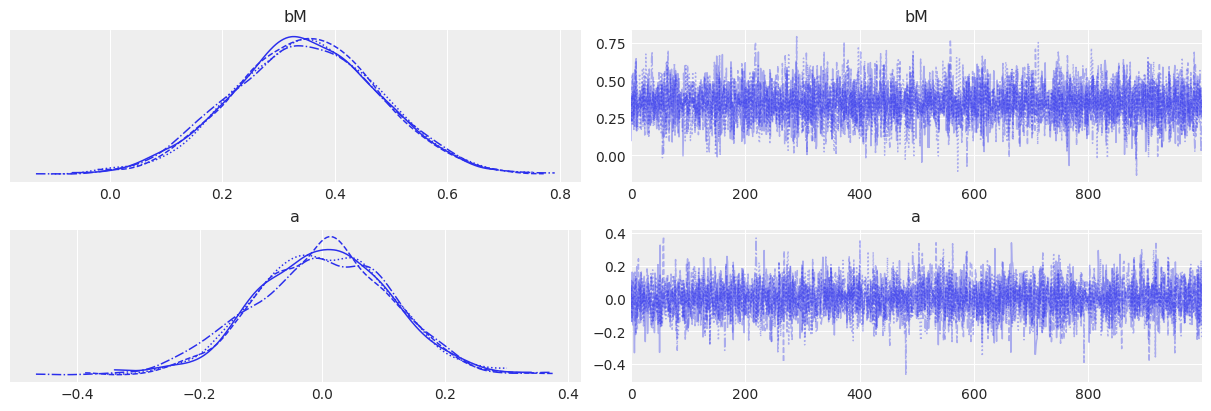

In [19]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

#### 5.7
Credit to [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/05_the_many_variables_and_the_spurious_waffles#Code-5.7)


Author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other. 

How do we understand all this ?

He explains that here we may want to think **causally**. 

Few interesting assumptions (or rather deductions) -

* a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

* b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

* c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D

M -> D

A -> M

and yet another way is to use **DAG** (Directed Acyclic Graphs)


/home/gretar/Git/LEARNING/Bayesian_Statistics/statistical_rethinking/python-version/env/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/home/gretar/Git/LEARNING/Bayesian_Statistics/statistical_rethinking/python-version/env/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


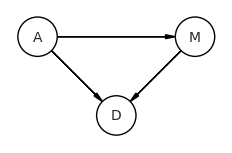

In [20]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**.

**MEDIATION** - Let's say that **A** did not directly influence **D**; rather it did it via **M**. This type of relationship is called *Mediation*


Author raises many interesting questions here. He asks if there is indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a **spurious** correlation between marriage rate and divorce rate


#### 5.8

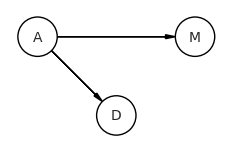

In [21]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

We can get the joint probability distribution implied by our causal graphical model using

In [22]:
print(dag5_2.get_distribution())

P(A)P(D|A)P(M|A)


To see the Conditional Independencies, we can use one of the following two snippets. The explanation is that **M** and **D** are not independent, unless we condition on **A** when they become conditionally independent.

In [23]:
dag5_2.get_all_independence_relationships()

[('D', 'M', {'A'})]

In [24]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('D', 'M', {'A'})


#### 5.9

Checking the independencies in the first DAG

In [25]:
DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

Executing above cell should not display anything as in the DAG1 (where all nodes are connected to each other) there are no conditional independencies.

#### 5.10

Multiple regression to model the divorse rate in a state given the median age when merried (in a state) and the state's marriage rate.

In [26]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"].values + bA * data["MedianAgeMarriage_std"].values
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [27]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.104,-0.190,0.196,0.002,0.002,3892.0,2799.0,1.0
bM,-0.055,0.160,-0.335,0.268,0.003,0.002,2396.0,2297.0,1.0
bA,-0.599,0.160,-0.906,-0.304,0.003,0.002,2520.0,2551.0,1.0
sigma,0.830,0.089,0.669,0.997,0.002,0.001,3256.0,2627.0,1.0


#### 5.11

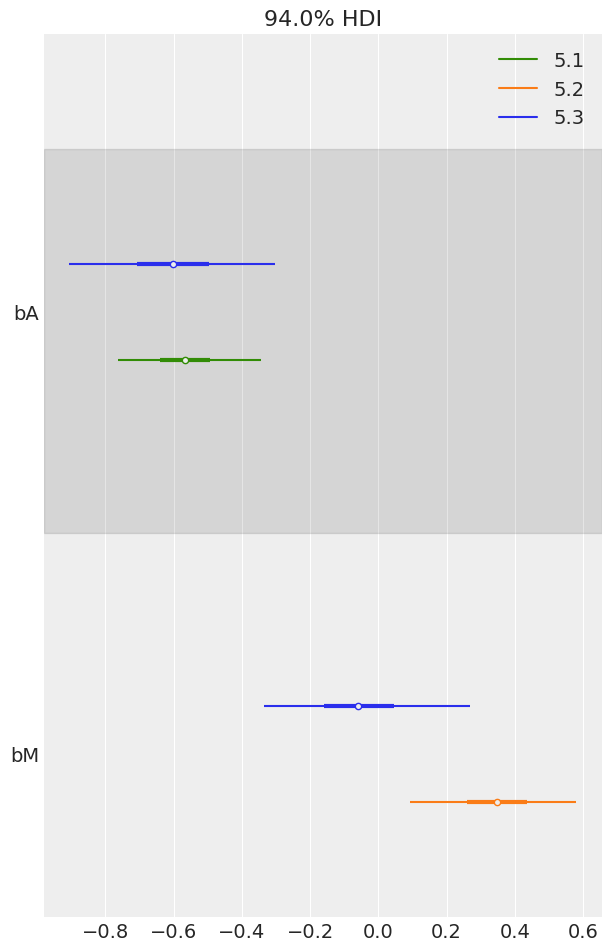

In [28]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True,
);

#### 5.12

In [29]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

# 5.1.5 Plotting multivariate posteriors

There is a huge literature detailing a variety of plotting techniques that all attempt to help one understand multiple linear regression. None of these techniques is suiteble for all jobs, and most do not generalize beyond linear regression.

1. *Predictor residual plots*: These plots show the outcome against residual predictor values. They are useful for understanding the statistical model, but not much else.
2. *Posterior prediction plots*: These show model-based predictions agains raw data, or otherwise display the error in prediction. They re tools for checking fit and assessing predictons. They are not causal tools.
3. *Counterfactual plots*: These show the implied predictions for imaginary experiments. These plots allow you to explore the causal implications of manipulating one or more variables.

### Prediction residual plots

A predictor residual is the average prediction error when we use all of the other predictor variables to model a preditor of interest. 

#### 5.13

In [30]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"].values)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Sampling: [Marriage_std, a, bAM, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


#### 5.14

### GaG notes -- **[[important]]**
It is interesting to look into how this is done using pymc and sampling algorithm (markov chain models). The posterior distribution is calculated by sampling from the posterior distribution. Sampling is the best we ca do in most cases to estimate the posterior probability distribution. For each draw of the data the determanistic part (`mu` in our case) is calculated **using the data** and **a draw from the posterior distribution**. 

**Example:**

Lets look at the first data point in the dataset and the first draw. The first draw was a = 0.045748 bAM = -0.807939. Within each draw the mu_dim_0 gives you the empirical value of mu, given the data, for that draw. For example the first state is alabama, the `MedianAgeMarriage_std = -0.606290`. For the first draw the mu is then `mu = a + bAM * MedianAgeMarriage_std` => `mu = 0.045748 + (- 0.807939 * -0.606290) = 0.53559333631`. 

I saved a run of the model because the numbers will of course change everytime we run.

| chain | draw | mu_dim_0 | a        | bAM      | sigma    | mu       |
|-------|------|----------|----------|----------|----------|----------|
| 0     | 0    | 0        | 0.045748 | -0.807939| 0.576158 | 0.535593 |
| 1     |      |          | 0.045748 | -0.807939| 0.576158 | 0.600559 |
| 2     |      |          | 0.045748 | -0.807939| 0.576158 | 0.210762 |
| ...   | ...  | ...      | ...      | ...      | ...      | ...      |
| 48    |      |          | -0.040321| -0.634721| 0.692181 | -0.165874|
| 49    |      |          | -0.040321| -0.634721| 0.692181 | 0.       |



`0.045748 + (- 0.807939 * -0.606290) = 0.53559333631`


So now it should be trivial to understand the rest of the code and why you can take the mean over the chain and the draw to get an estimate from the posterior distribution of the mean marriage rate for each state. 

In [31]:
m_5_4_trace.posterior.to_dataframe()

a       bAM     sigma        mu
chain draw mu_dim_0                                        
0     0    0         0.027619 -0.752450  0.658627  0.483821
           1         0.027619 -0.752450  0.658627  0.544325
           2         0.027619 -0.752450  0.658627  0.181300
           3         0.027619 -0.752450  0.658627  1.088864
           4         0.027619 -0.752450  0.658627 -0.423743
...                       ...       ...       ...       ...
3     999  45        0.178147 -0.710876  0.671181 -0.019631
           46        0.178147 -0.710876  0.671181  0.266176
           47        0.178147 -0.710876  0.671181  0.780628
           48        0.178147 -0.710876  0.671181  0.037530
           49        0.178147 -0.710876  0.671181  1.237919

[200000 rows x 4 columns]

In [32]:
0.045748 + (- 0.807939 * -0.606290)

0.53559333631

In [33]:
data

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,Divorce_std,Marriage_std,MedianAgeMarriage_std
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.450000,1.654205,0.022644,-0.606290
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.000000,1.544364,1.549802,-0.686699
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.000000,0.610716,0.048974,-0.204241
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.260000,2.093569,1.655123,-1.410387
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.000000,-0.927058,-0.266989,0.599857
5,Colorado,CO,5.03,25.7,23.5,1.24,11.6,0.94,11,0,0,34277,0.000000,1.050080,0.891544,-0.284651
6,Connecticut,CT,3.57,27.6,17.1,1.06,6.7,0.77,0,0,0,460147,0.000000,-1.641024,-0.793595,1.243135
7,Delaware,DE,0.90,26.6,23.1,2.89,8.9,1.39,3,0,1798,112216,0.016000,-0.432773,0.786223,0.439037
8,District of Columbia,DC,0.60,29.7,17.7,2.53,6.3,1.89,0,0,0,75080,0.000000,-1.860706,-0.635614,2.931739
9,Florida,FL,18.80,26.4,17.0,0.58,8.5,0.32,133,1,61745,140424,0.440000,-0.652455,-0.819926,0.278218


In [34]:
mu_m_5_4_mean = m_5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m_5_4_mean

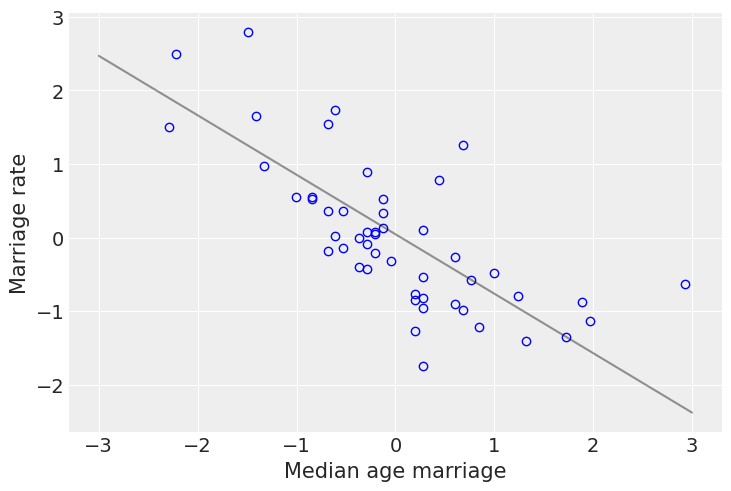

In [35]:
# give me a plot of marriage rate vs median age marriage
fig, ax = plt.subplots()
ax.scatter(data["MedianAgeMarriage_std"], data["Marriage_std"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Marriage rate")
# can you ad a line of best fit?
x = np.linspace(-3, 3, 50)
y = 0.046 + (-0.808 * x)
ax.plot(x, y, c="black", alpha=0.4)
plt.show()


## 5.1.5.2 - Posterior prediction plots

#### 5.15
We can skip most of the code with the posterior predictive plot functionality in pymc


**Remember - hdi**

The az.hdi function from the ArviZ library calculates the highest posterior density interval (HDI) of the posterior predictive simulations.
 The HDI is an interval estimate that gives a range where a parameter value lies with a certain probability.
  In this case, the probability is 0.89 or 89%, so you're calculating the range in which mu and divorce_rate_std lie with 89% certainty based on the posterior predictive simulations.

In summary, the hdi function is used to calculate the 89% highest density interval for the given posterior predictive simulations.
**This interval provides a range where the true parameter value is likely to be found with an 89% probability.**

In [36]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(m_5_3_trace, var_names=["mu", "divorce_rate_std"])


mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

Sampling: [divorce_rate_std]


In [37]:
mu_PI

<xarray.Dataset>
Dimensions:   (mu_dim_2: 50, hdi: 2)
Coordinates:
  * mu_dim_2  (mu_dim_2) int64 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * hdi       (hdi) <U6 'lower' 'higher'
Data variables:
    mu        (mu_dim_2, hdi) float64 0.1336 0.5778 -0.01932 ... 0.2155 1.32

#### 5.16

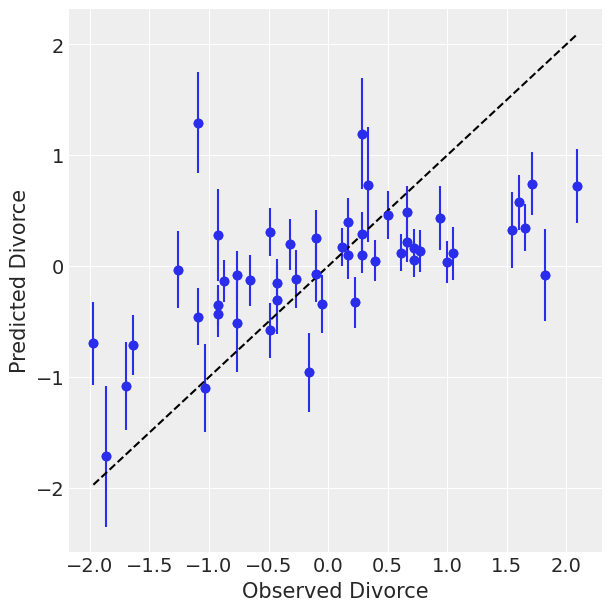

In [38]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()), # The error bar size
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim) # GaG notes: This line does not do anything, its the error bar

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

#### 5.18

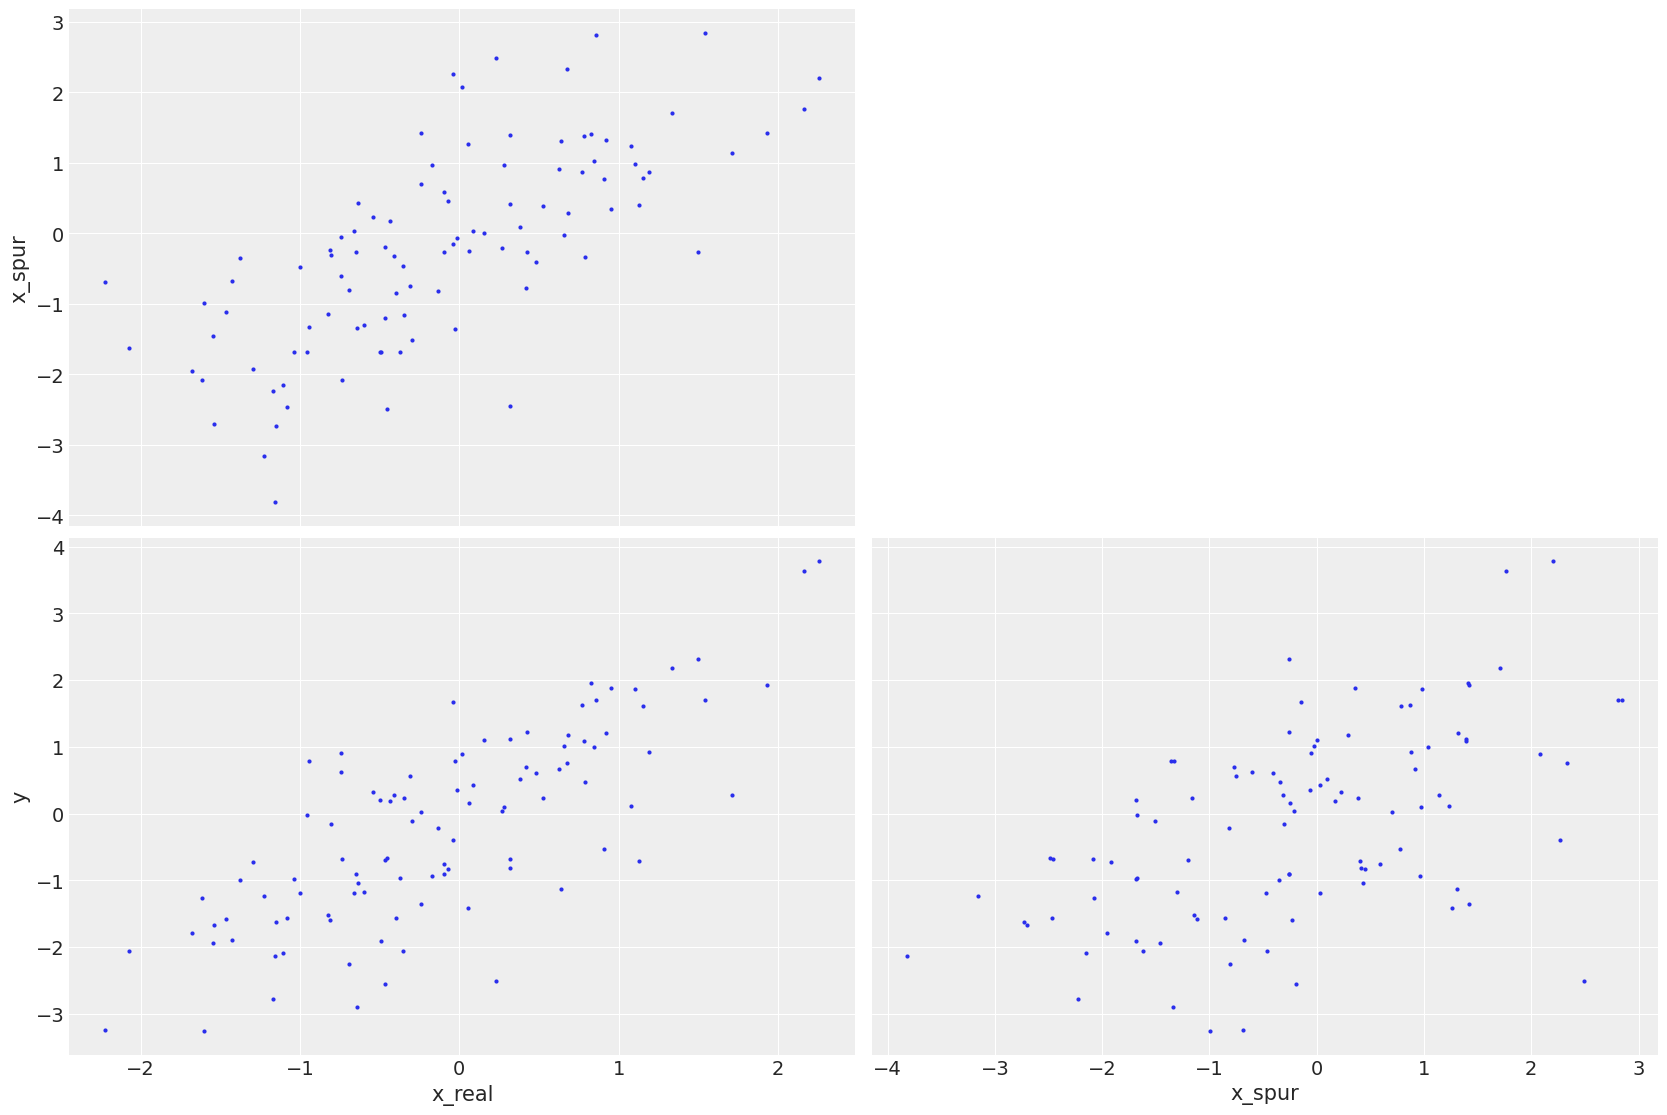

In [39]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

## 5.1.5.3 - Counterfactual plots

Displays the causal implications of the model.

The simplest use of a counterfactual plot is to see how the outcome would change as you change one predictor at a time. If some predictor X took on a new value for one or more cases inour data, how would the outcome Y have changed? Changing just one predictor X might also change other predictors, depending upon the causal model.

Let's se how to generate plots of model predictions that take the causal structure into account. The basic recipe is:
1. Pick a varaible to manipulate, the intervention variable.
2. Define the range of values to set the intervention variable to.
3. For each value of the intervention variable, and for each sample in posterior, use the causal model to simulate the values of other variables, including the outcome.
In the end you end up with a posterior distribution of counterfactual outcomes that you cn plot ans summerized in various ways, depending upon your goal.


## Note:

I did not try hard to understand this subsubchapter. The code does not work and I would need a bit of work to get it to work. I decited to just move on and review this chapter if I need it in the future.

#### 5.19

In [57]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

# Use Aesara shared variables so we can change them later
#marriage_shared = shared(data["Marriage_std"].values)
#age_shared = shared(data["MedianAgeMarriage_std"].values)
marriage_shared = data["Marriage_std"].values
age_shared = data["MedianAgeMarriage_std"].values

with pm.Model() as m5_3_A:
    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bA * age_shared + bM * marriage_shared)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("bAM", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_shared)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"].values)

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bA, bM, a, sigma_m, bAM, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### 5.20

In [58]:
# We're setting this to 50 to match the shape of our input
A_seq = np.linspace(-2, 2, 50)
A_seq.shape

(50,)

#### 5.21

In [60]:
# With PyMC we have to simulate in each model separately

# Simulate the marriage rates at each age first
age_shared.set_value(A_seq)
#
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

AttributeError: 'numpy.ndarray' object has no attribute 'set_value'

#### 5.22

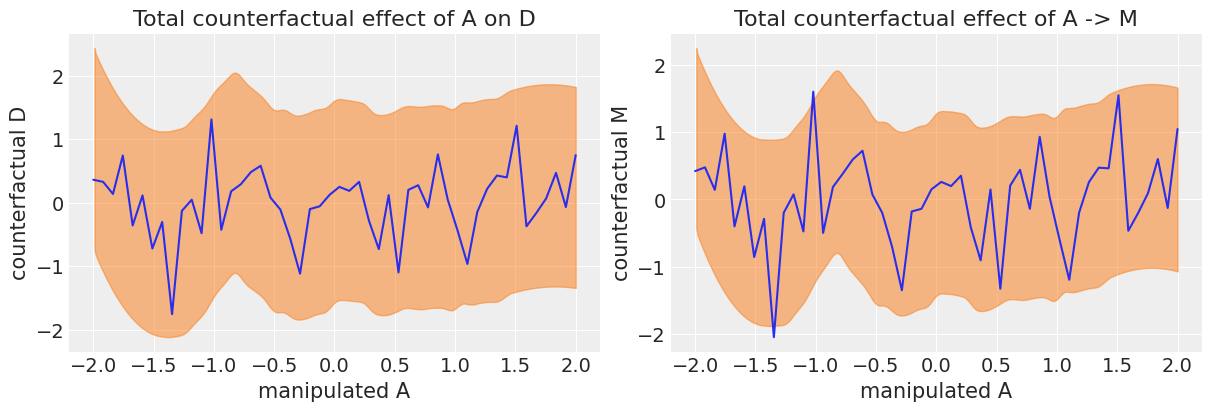

In [61]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["divorce"], ax=ax[0])
ax[0].plot(A_seq, m5_3_M_marriage.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(A_seq, m5_3_M_marriage.posterior_predictive["marriage"], ax=ax[1])
ax[1].plot(A_seq, m5_3_M_marriage.posterior_predictive["marriage"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

#### 5.23

In [62]:
# We're setting this to 50 to match the shape of our input
A_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24

age_shared.set_value(A_seq)

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# Average first and last column and take difference
(
    m5_3_M_ppc.posterior_predictive["divorce"][:, -1].mean()
    - m5_3_M_ppc.posterior_predictive["divorce"][:, 0].mean()
)

AttributeError: 'numpy.ndarray' object has no attribute 'set_value'

#### 5.24

In [ ]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_shared.set_value(marriage_counter_factual_x)

# Fix age to zero
age_shared.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

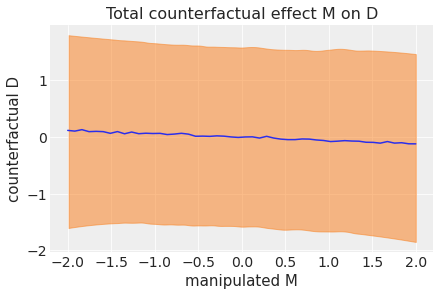

In [ ]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc.posterior_predictive["divorce"], ax=ax)
ax.plot(
    marriage_counter_factual_x,
    m5_3_M_ppc.posterior_predictive["divorce"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

#### 5.25

In [ ]:
A_seq = np.linspace(-2, 2, 30)

#### 5.26

In [ ]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_m", "aM", "bAM"]
    )

In [ ]:
marriage_mu_counterfactual = np.outer(
    m5_3_M_marriage.posterior_predictive["aM"] + m5_3_M_marriage.posterior_predictive["bAM"], A_seq
)
marriage_mu_counterfactual.shape

(4000, 30)

In [ ]:
mu = marriage_mu_counterfactual.T
sigma = az.extract_dataset(m5_3_M_marriage.posterior_predictive["sigma_m"]).to_array()
M_sim = stats.norm(loc=mu, scale=sigma).rvs()
M_sim.shape

(30, 4000)

#### 5.27

In [ ]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma", "bM", "bA", "a"]
    )

In [ ]:
D_sim = np.zeros((30, 4000))
a = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["a"]).to_array())
bM = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bM"]).to_array())
bA = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["bA"]).to_array())
sigma = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["sigma"]).to_array())

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA * age_counterfactual + bM * M_sim[i, :]
    samples = stats.norm(divorce_mu_counterfactual, sigma).rvs()
    D_sim[i, :] = samples

# 5.2 Masked relationships

A second reason to use more than one predictor variable is to measure the direct influences of multiple factors on an outcome, when none of those influences is apparent from bivariate relationships. This kind of problem tends to arise when there are two predictor variables that are correlated with one another. However, one of these is positively correlated with the outcome and the other is negatively correlated with it.

## 5.28 Read in the data

Composition of mikl across primate species, as well as some facts about those species, like body mass and brain size.

```
kcal.per.g = kilocalories of energy per gram of milk.
mass = average femail body mass, in kilograms.
neocortex.perc = percent of total brain mass that is neocortex mass.
```

In [73]:
d = pd.read_csv("../Data/milk.csv", delimiter=";")
d.head()


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.29 standardize

The question that we are going to explore is **to what extent energy content of milk, measured here by kilocalories, is related to the percent of the brain mass that is neocortex**.

In [74]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

In [76]:
d

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN,-0.816126,NaN,-0.510160
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN,-1.125913,NaN,-0.493204
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN,-1.001998,NaN,-0.529134
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN,-0.258511,NaN,-0.506123
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN,1.662163,NaN,-0.565871
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082


#### 5.30

In [75]:
# This is meant to fail!
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"].values)

    K = pm.Normal("K", mu, sigma, observed=d["K"].values)

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(-0.42459352), 'bN': array(-0.11185371), 'a': array(-0.76916815)}

Logp initial evaluation results:
{'sigma': -1.08, 'bN': -0.93, 'a': -1.21, 'K': nan}
You can call `model.debug()` for more details.

#### 5.32

In [ ]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

#### 5.32

In [78]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

In [79]:
dcc

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc,K,N,M
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16,-0.940041,-2.080196,-0.515812
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54,-1.063955,-0.508641,-0.382588
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54,-0.506340,-0.508641,-0.377744
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64,1.538249,0.010742,-0.493204
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85,1.724120,0.213470,-0.567082
10,New World Monkey,Cebuella pygmaea,0.80,41.35,20.85,37.80,0.12,58.85,0.980633,-1.461962,-0.589690
11,New World Monkey,Callimico goeldii,0.46,3.93,25.30,70.77,0.47,61.69,-1.125913,-0.986139,-0.575560
12,New World Monkey,Callithrix jacchus,0.71,38.38,20.09,41.53,0.32,60.32,0.423018,-1.215673,-0.581616
15,Old World Monkey,Miopithecus talpoin,0.68,40.15,18.08,41.77,1.55,69.97,0.237147,0.401118,-0.531960
17,Old World Monkey,M mulatta,0.97,55.51,13.17,31.32,3.24,70.41,2.033906,0.474837,-0.463734


#### 5.33

In [81]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()

NotImplementedError: Cannot convert bN to a tensor variable.

#### 5.34

In [ ]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5_draft:
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

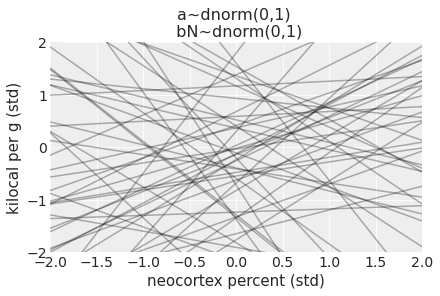

In [ ]:
fig, ax = plt.subplots()

ppr_K = m5_5_draft_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.35

In [ ]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample()

m5_5_data = az.extract_dataset(m5_5_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


In [ ]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5:
    m5_5_prior_predictive = pm.sample_prior_predictive()

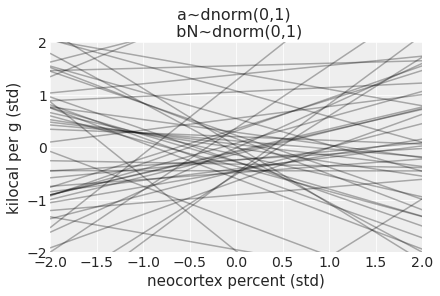

In [ ]:
fig, ax = plt.subplots()

ppr_K = m5_5_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.36

In [ ]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.033,0.161,-0.263,0.347,0.003,0.003,3967.0,2421.0,1.0
bN,0.123,0.243,-0.321,0.582,0.004,0.003,4216.0,2758.0,1.0
sigma,1.114,0.207,0.779,1.497,0.003,0.002,4199.0,2795.0,1.0


#### 5.37

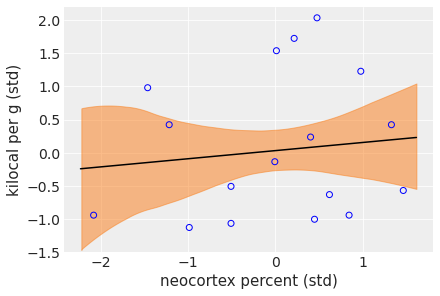

In [ ]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"])

mu_ppd = m5_5_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.38

In [ ]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.extract_dataset(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bM, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bM,-0.306,0.242,-0.789,0.120,0.004,0.003,4344.0,2989.0,1.0
a,0.044,0.158,-0.259,0.318,0.002,0.002,4699.0,2593.0,1.0
sigma,1.060,0.201,0.731,1.443,0.003,0.002,3701.0,2119.0,1.0


#### 5.39

In [ ]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.extract_dataset(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, bM, a]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 49 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.060,0.152,-0.222,0.352,0.001,0.001,33132.0,27357.0,1.0
bN,0.380,0.259,-0.119,0.858,0.002,0.001,24784.0,22994.0,1.0
bM,-0.513,0.271,-1.004,0.017,0.002,0.001,23848.0,22770.0,1.0
sigma,0.970,0.193,0.651,1.335,0.001,0.001,25911.0,22398.0,1.0


#### 5.40

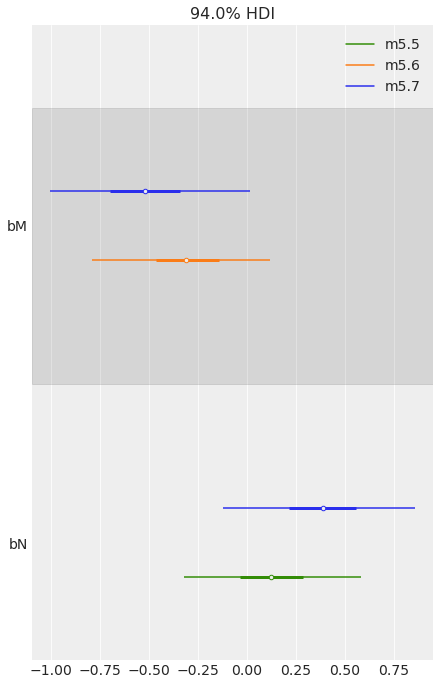

In [ ]:
az.plot_forest(
    [m5_7_trace, m5_6_trace, m5_5_trace],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);

#### 5.41
This code actually produces right plot Confirned from Professor McElreath that the book text is mistaken.

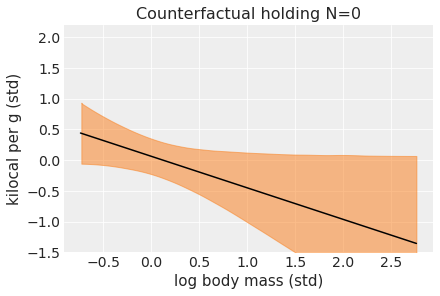

In [ ]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])

mu_ppd = m5_7_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

#### 5.42

In [ ]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

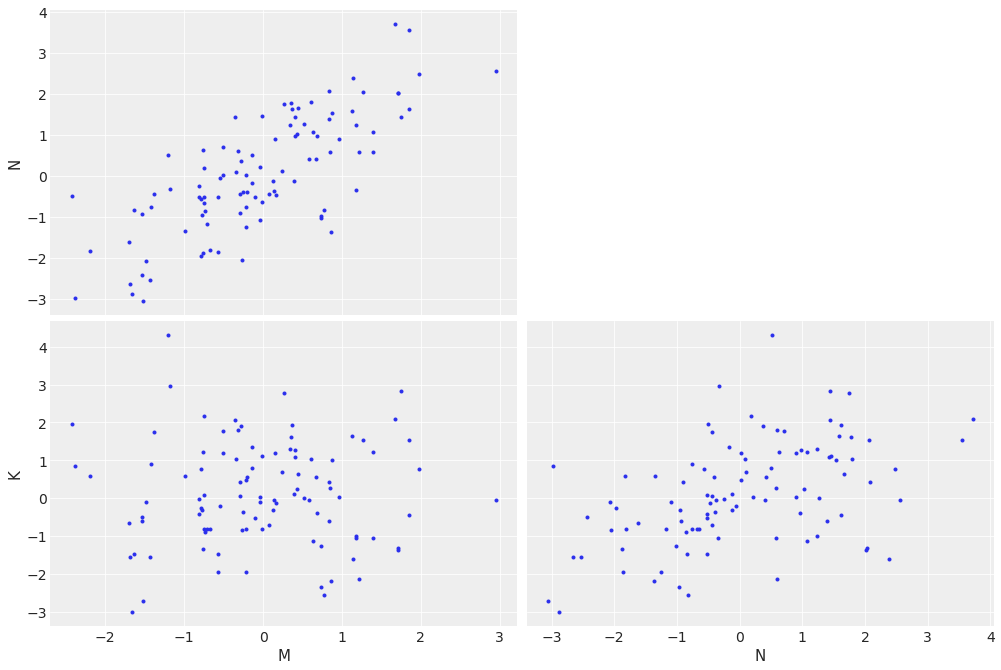

In [ ]:
# Professor McElreath suggests viewing the pair plots
az.plot_pair({"M": M, "N": N, "K": K});

#### 5.43

In [ ]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

#### 5.45

In [ ]:
d = pd.read_csv(os.path.join("Data", "Howell1.csv"), delimiter=";")
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


#### 5.46

In [ ]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

,mean,sd,hdi_3%,hdi_97%
mu_female,176.918,19.091,141.103,212.153
mu_male,177.696,22.989,135.588,221.674


#### 5.47

In [ ]:
sex = d["male"].values

#### 5.48

In [ ]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.936,1.695,131.786,137.962,0.023,0.016,5634.0,3251.0,1.0
mu[1],142.576,1.750,139.176,145.690,0.026,0.018,4494.0,3008.0,1.0
sigma,27.423,0.851,25.827,29.031,0.011,0.008,5779.0,3101.0,1.0


#### 5.49

In [ ]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)

    # With PyMC it's easier just to create a deterministic that includes both values
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[0],134.891,1.680,131.829,138.050,0.024,0.017,4904.0,2827.0,1.0
mu[1],142.600,1.702,139.324,145.667,0.025,0.017,4771.0,3040.0,1.0
sigma,27.436,0.860,25.889,29.090,0.012,0.009,4944.0,2769.0,1.0
diff,-7.709,2.400,-12.198,-3.225,0.033,0.025,5185.0,2877.0,1.0


#### 5.50

In [ ]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.51

In [ ]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

#### 5.52

In [ ]:
d["clade_id"].max() + 1

4

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


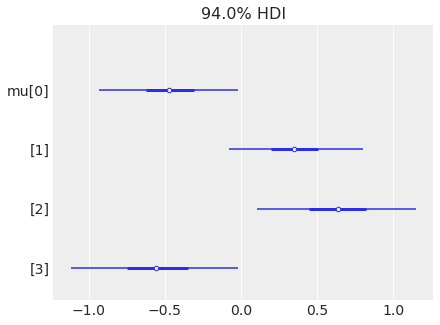

In [ ]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=[d["clade_id"].max() + 1])
    K = pm.Normal("K", mu[d["clade_id"].values], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);

#### 5.53

In [ ]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

#### 5.54

In [ ]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=[d["house"].max() + 1])
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=[d["clade_id"].max() + 1])
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu_house, mu_clade]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_clade[0],-0.362,0.290,-0.907,0.198,0.005,0.004,3159.0,3182.0,1.0
mu_clade[1],0.363,0.295,-0.205,0.908,0.005,0.004,3188.0,3222.0,1.0
mu_clade[2],0.557,0.314,-0.013,1.179,0.005,0.004,3375.0,2916.0,1.0
mu_clade[3],-0.466,0.325,-1.076,0.143,0.005,0.004,3786.0,2837.0,1.0
mu_house[0],0.123,0.324,-0.469,0.729,0.005,0.005,3503.0,2977.0,1.0
mu_house[1],-0.357,0.286,-0.885,0.181,0.005,0.004,3087.0,2976.0,1.0
mu_house[2],0.049,0.285,-0.458,0.602,0.005,0.004,3304.0,2820.0,1.0
mu_house[3],0.288,0.325,-0.372,0.856,0.005,0.004,3569.0,3305.0,1.0


In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Jul 09 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

arviz     : 0.12.1
numpy     : 1.22.1
pymc      : 4.0.0
pandas    : 1.4.2
matplotlib: 3.5.2
scipy     : 1.7.3
daft      : 0.1.2

Watermark: 2.3.1

